In [1]:
%run to_import.py
%matplotlib inline

In [2]:
segm_set=range(1,13)
data_folder='../../../Data_Raw'
data_folder_in='../../Data'
data_small='../../Data_Small_Tables'

## fit all data

In [ ]:
replicas_all=range(13)
for segment in segm_set:
    replicas_all[segment]=pd.read_csv(data_folder+'/S'+str(segment)+'_merged_filtered_sum_10_size_4_with_fr.csv',sep='\t',index_col=0)

In [ ]:
#download k and s12 parameters
table_s12_k=pd.read_csv(data_small+'/table_s12_k_with_nons.csv',sep='\t',index_col=0)

In [ ]:
#calsualte fit for each point 
for s in segm_set:
    print 'S'+str(s)
    replicas_all[s]=replicas_all[s][['seq','aa_seq','t0_fr','t1_fr','t2_fr','t0_fr_var','t1_fr_var','t2_fr_var']]
    data=replicas_all[s][['t0_fr','t1_fr','t2_fr']].values.copy()
    data_sigma=np.sqrt(replicas_all[s][['t0_fr_var','t1_fr_var','t2_fr_var']].values.copy())
    
    s12=table_s12_k.loc['S'+str(s),'s12']
    k=table_s12_k.loc['S'+str(s),'k']
    
    y0,si,y0_std,s_std,residuals=func_fit_single_exponents(data,data_sigma,s12,k)
    replicas_all[s]['y0']=y0
    replicas_all[s]['s']=si
    replicas_all[s]['y0_std']=y0_std
    replicas_all[s]['s_std']=s_std
    replicas_all[s]['residuals']=residuals
    replicas_all[s].to_csv(data_folder+'/S'+str(s)+'_sum_10_size_4_fit'+'.csv',sep='\t')

### Calculate Errors

In [5]:
aa_all=range(13)
for segment in segm_set:
    aa_all[segment]=pd.read_csv(data_folder_in+'/S'+str(segment)+'_scaled_info.csv',sep='\t')

In [11]:
replicas_all=range(13)
for segment in segm_set:
    replicas_all[segment]=pd.read_csv(data_folder+'/S'+str(segment)+'_sum_10_size_4_fit'+'.csv',sep='\t',index_col=0)

In [ ]:
nucl_fit_er=range(13)
for segment in segm_set:
    time_0=time.time()
    tmp=[]
    aa_seqs=aa_all[segment][aa_all[segment]['size']>=2]['aa_seq'].values

    for aa_seq in aa_seqs:
        mask=replicas_all[segment][replicas_all[segment]['aa_seq']==aa_seq]
        t0_ij=mask['t0_fr'].values
        s_ij=mask['s'].values
        for i in range(0,len(mask)):
            for j in range(i+1,len(mask)):
                tmp.append([t0_ij[i],t0_ij[j],s_ij[i],s_ij[j]])
    print segment,len(tmp),time.time()-time_0
    nucl_fit_er[segment]=pd.DataFrame()
    nucl_fit_er[segment]=nucl_fit_er[segment].append(tmp)
    nucl_fit_er[segment].rename(columns={0:'t0_1',1:'t0_2',2:'s_1',3:'s_2'},inplace=True)
    nucl_fit_er[segment]['s_mean']=0.5*(nucl_fit_er[segment]['s_1']+nucl_fit_er[segment]['s_2'])
    nucl_fit_er[segment]['s_diff']=abs(nucl_fit_er[segment]['s_1']-nucl_fit_er[segment]['s_2'])
    nucl_fit_er[segment]['t0_weight']=1./(1./nucl_fit_er[segment]['t0_1']+1./nucl_fit_er[segment]['t0_2'])
    nucl_fit_er[segment].to_csv(data_folder+'/S'+str(segment)+'_nucl_fit_er_full'+'.csv',sep='\t',index=False)

### Analyse Errors

In [3]:
#download data
nucl_fit_er=range(13)
for segment in segm_set:
    nucl_fit_er[segment]=pd.read_csv(data_folder+'/S'+str(segment)+'_nucl_fit_er_full'+'.csv',sep='\t')
    nucl_fit_er[segment]['t0_min']=nucl_fit_er[segment][['t0_1','t0_2']].min(axis=1)

In [4]:
#some statistics
for segment in segm_set:
     print 'S'+str(segment),len(nucl_fit_er[segment]),\
        len(nucl_fit_er[segment][nucl_fit_er[segment]['s_mean']<0]),\
        len(nucl_fit_er[segment][nucl_fit_er[segment]['s_mean']>=0])

S1 3083985 718071 2365306
S2 1783916 650755 947467
S3 10895276 2029830 8790559
S4 5345643 45439 5298069
S5 7754767 1641862 6065294
S6 820529 246945 567588
S7 1158385 695648 455866
S8 504153 271559 217652
S9 134439 38424 39382
S10 695407 184648 470520
S11 677326 69680 499483
S12 1417550 148164 1248118


In [6]:
#create dist for avg statistics
nuc_fit_er_avg=range(13)
for segment in segm_set:
    nuc_fit_er_avg[segment]={'nan_fr':0,'t0':0,'t0_min_s<0':0,'s_diff_s<0':0,'t0_min_s>=0':0,'s_diff_s>=0':0}

In [7]:
#number of failure as function of t0
x_name='t0_fr'
dx=0.1
for segment in segm_set:
    mask=replicas_all[segment][pd.isnull(replicas_all[segment]['s'])]
    nuc_fit_er_avg[segment]['t0']=np.arange(0,50,dx)
    tmp=[]
    for i in nuc_fit_er_avg[segment]['t0']:
        tmp.append(np.divide(len(mask[(mask[x_name]>=i)&(mask[x_name]<i+dx)])*1.,
                  len(replicas_all[segment][(replicas_all[segment][x_name]>=i)&(replicas_all[segment][x_name]<i+dx)])))
    nuc_fit_er_avg[segment]['nan_fr']=tmp 

NameError: name 'replicas_all' is not defined

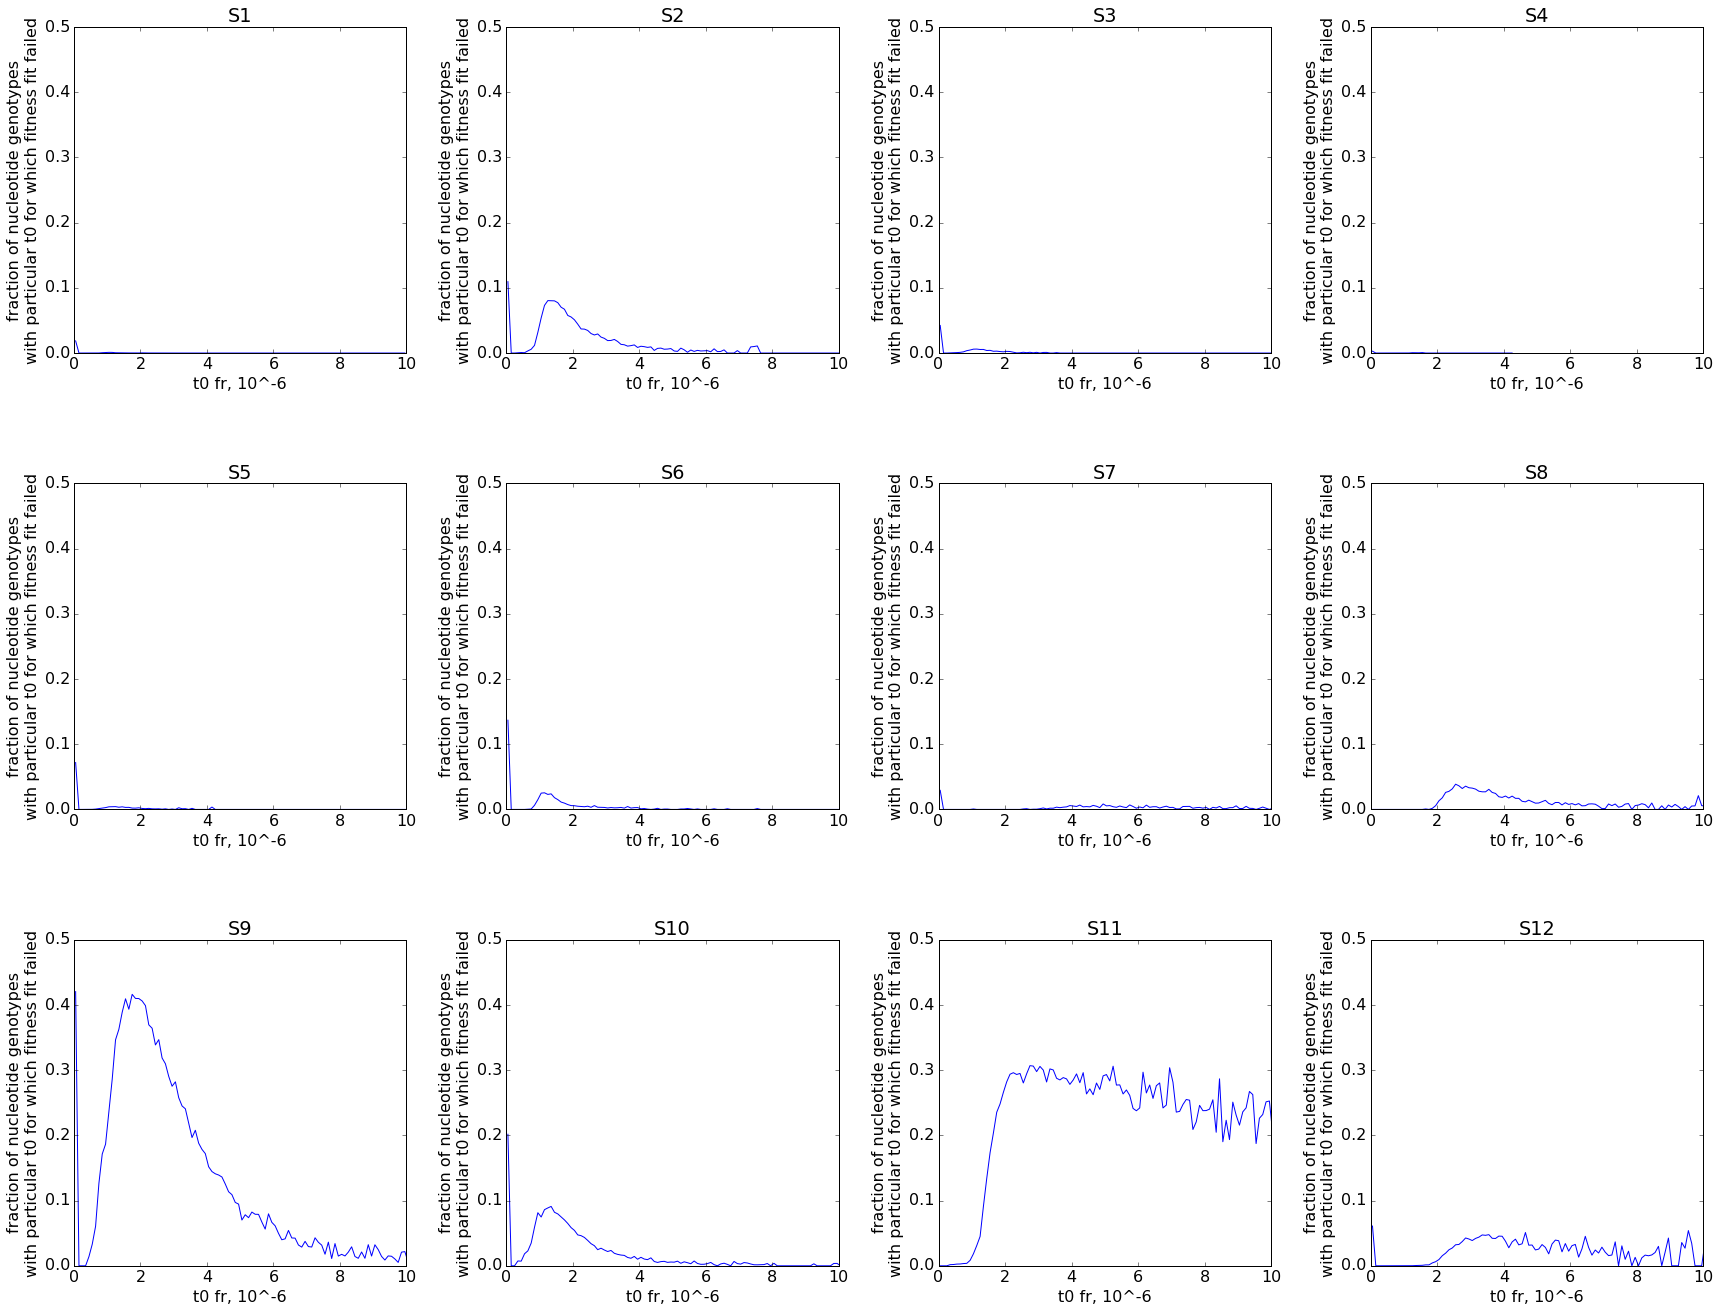

In [15]:
#plot number of failure as function of t0
fig=plt.figure(figsize=(4*7.3,3*7.4))
plt.rcParams.update({'font.size': 16,'legend.fontsize': 16})
plt.subplots_adjust(hspace = 0.4,wspace=0.3)
count=1
for segment in segm_set:
    plt.subplot(3,4,count)
    plt.plot(nuc_fit_er_avg[segment]['t0']+dx/2.,nuc_fit_er_avg[segment]['nan_fr'],alpha=1,c='b')
    count+=1  
    plt.title('S'+str(segment))
    plt.xlim(0,10)
    plt.ylim(0,0.5)
    plt.xlabel('t0 fr, 10^-6')
    plt.ylabel('fraction of nucleotide genotypes\nwith particular t0 for which fitness fit failed')

/users/fk/dusmanova/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


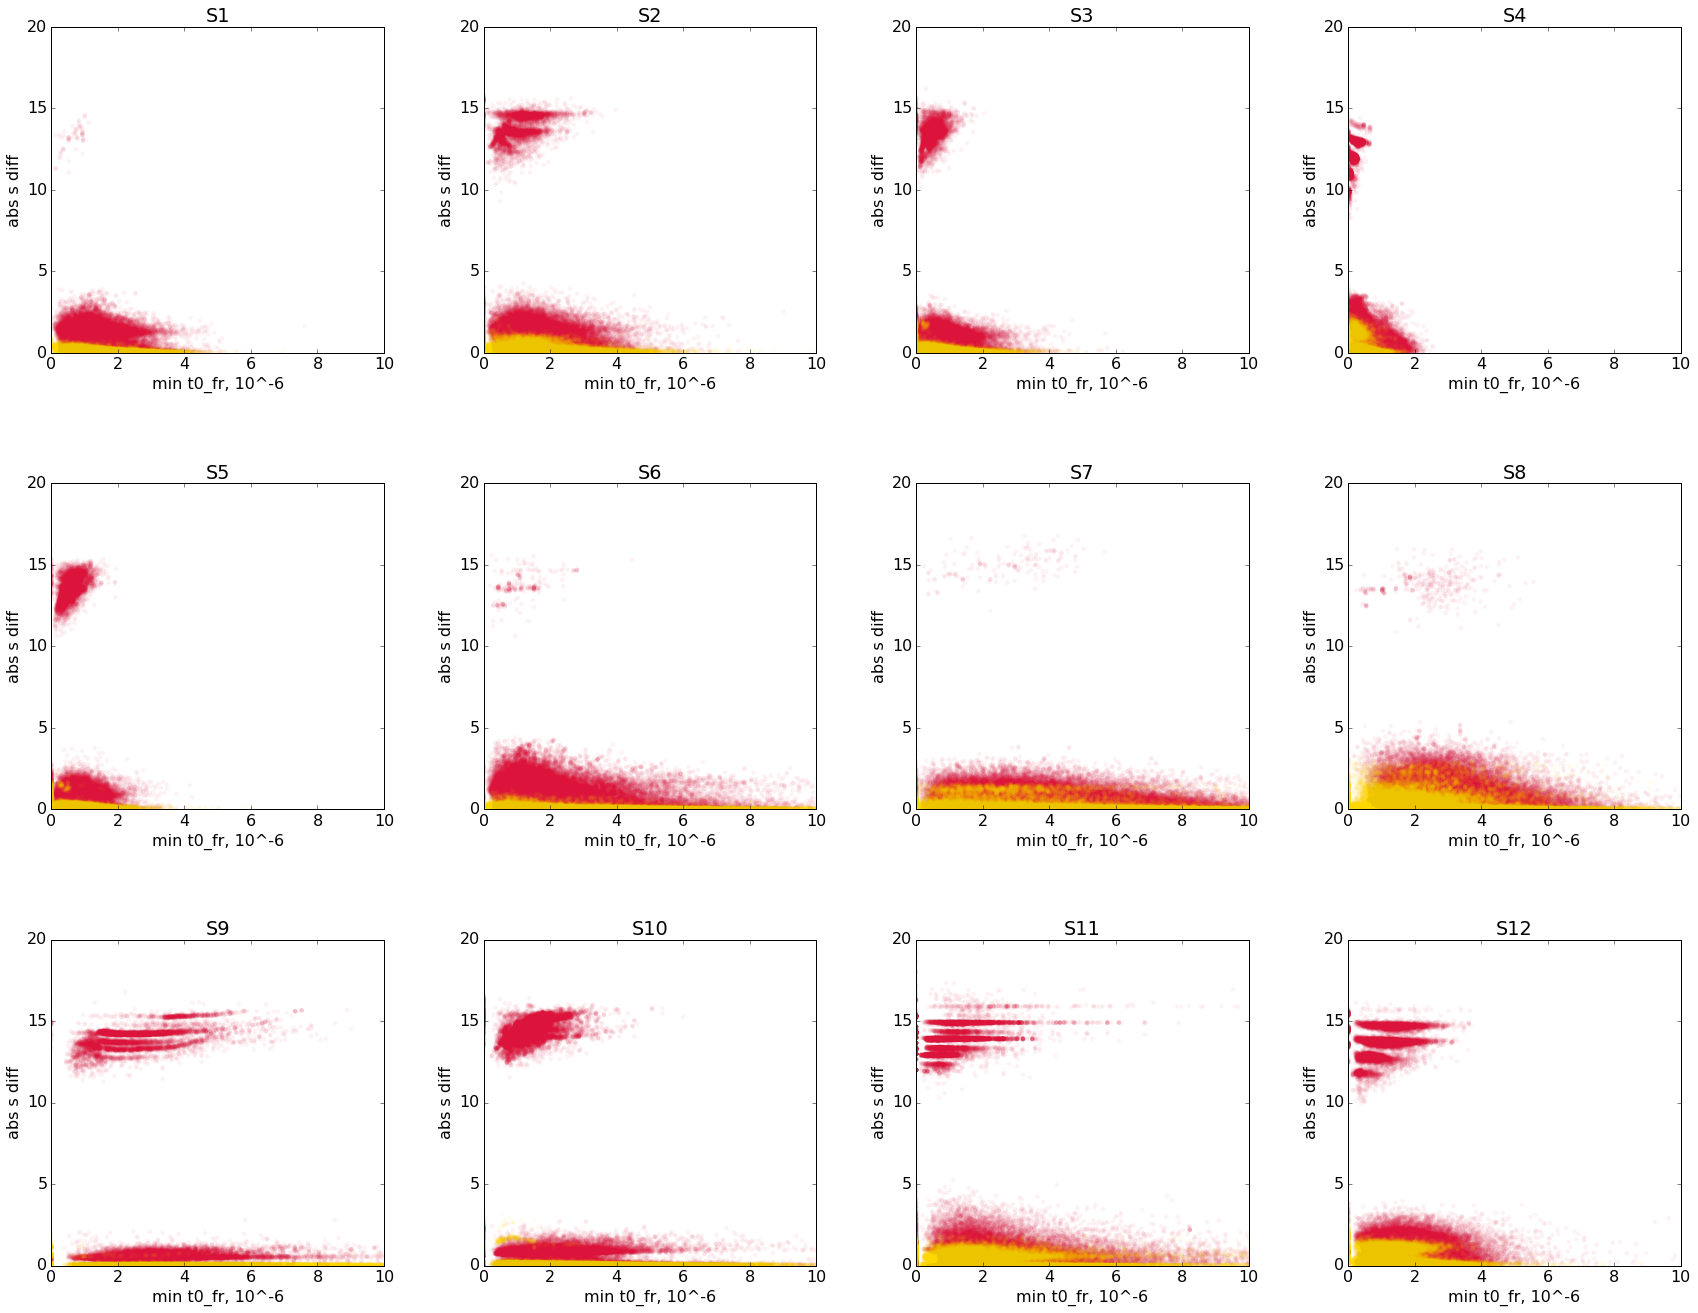

In [9]:
#calculate and plot fitness error as function of t0 and fitness (s<0 or s>=0)    
fig=plt.figure(figsize=(4*7.3,3*7.4))
plt.rcParams.update({'font.size': 16,'legend.fontsize': 16})
plt.subplots_adjust(hspace = 0.4,wspace=0.3)

count=1
for segment in segm_set:
    plt.subplot(3,4,count)
    x_name='t0_min'
    for mask,color,name in [
        [nucl_fit_er[segment][nucl_fit_er[segment]['s_mean']<0],'crimson','s<0'],
        [nucl_fit_er[segment][nucl_fit_er[segment]['s_mean']>=0],'gold','s>=0']
    ]:
        mask=mask.sample(min(len(mask),100000))

        [r,p]=stats.spearmanr(mask[x_name],mask['s_diff'])
        #plt.scatter(mask[x_name],mask['s_diff'],alpha=0.05,edgecolor='',c=color,label=None)

        #mask=mask.sort_values(by=x_name)
        #sample_size=200
        tmp_t0=[]
        tmp_s_diff=[]
        #for  i in range(0,len(mask)-sample_size,sample_size):
        #    mask_2=mask.iloc[i:i+sample_size]
        #    tmp_t0.append(np.mean(mask_2[x_name]))
        #    tmp_s_diff.append(np.mean(mask_2['s_diff']))
        boundaries=list(np.arange(0,1-0.01,0.1))+list(np.arange(1,3-0.01,0.2))+list(np.arange(3,10-0.01,0.5))+list(np.arange(10,20-0.01,1))
        for i in range(len(boundaries)-1):
            mask_2=mask[(mask[x_name]>=boundaries[i])&(mask[x_name]<boundaries[i+1])]
            tmp_s_diff.append(np.mean(mask_2['s_diff']))
            tmp_t0.append(np.mean(mask_2[x_name]))

        nuc_fit_er_avg[segment]['t0_min_'+name]=tmp_t0  
        nuc_fit_er_avg[segment]['s_diff_'+name]=tmp_s_diff  
        plt.plot(nuc_fit_er_avg[segment]['t0_min_'+name],nuc_fit_er_avg[segment]['s_diff_'+name],alpha=1,c='black',label='_nolegend_')
        plt.scatter( np.NaN, np.NaN, color=color,alpha=1, label='%s, mean=%.2f\nspR=%.2f p=%.0e' %(name,np.mean(mask['s_diff']),r,p))

    
    plt.legend(labelspacing=1,markerscale=5.)
    plt.title('S'+str(segment))
    plt.xlim(0,10)
    plt.ylim(0,20)
    plt.xlabel('min t0_fr, 10^-6')
    plt.ylabel('abs s diff')
    count+=1

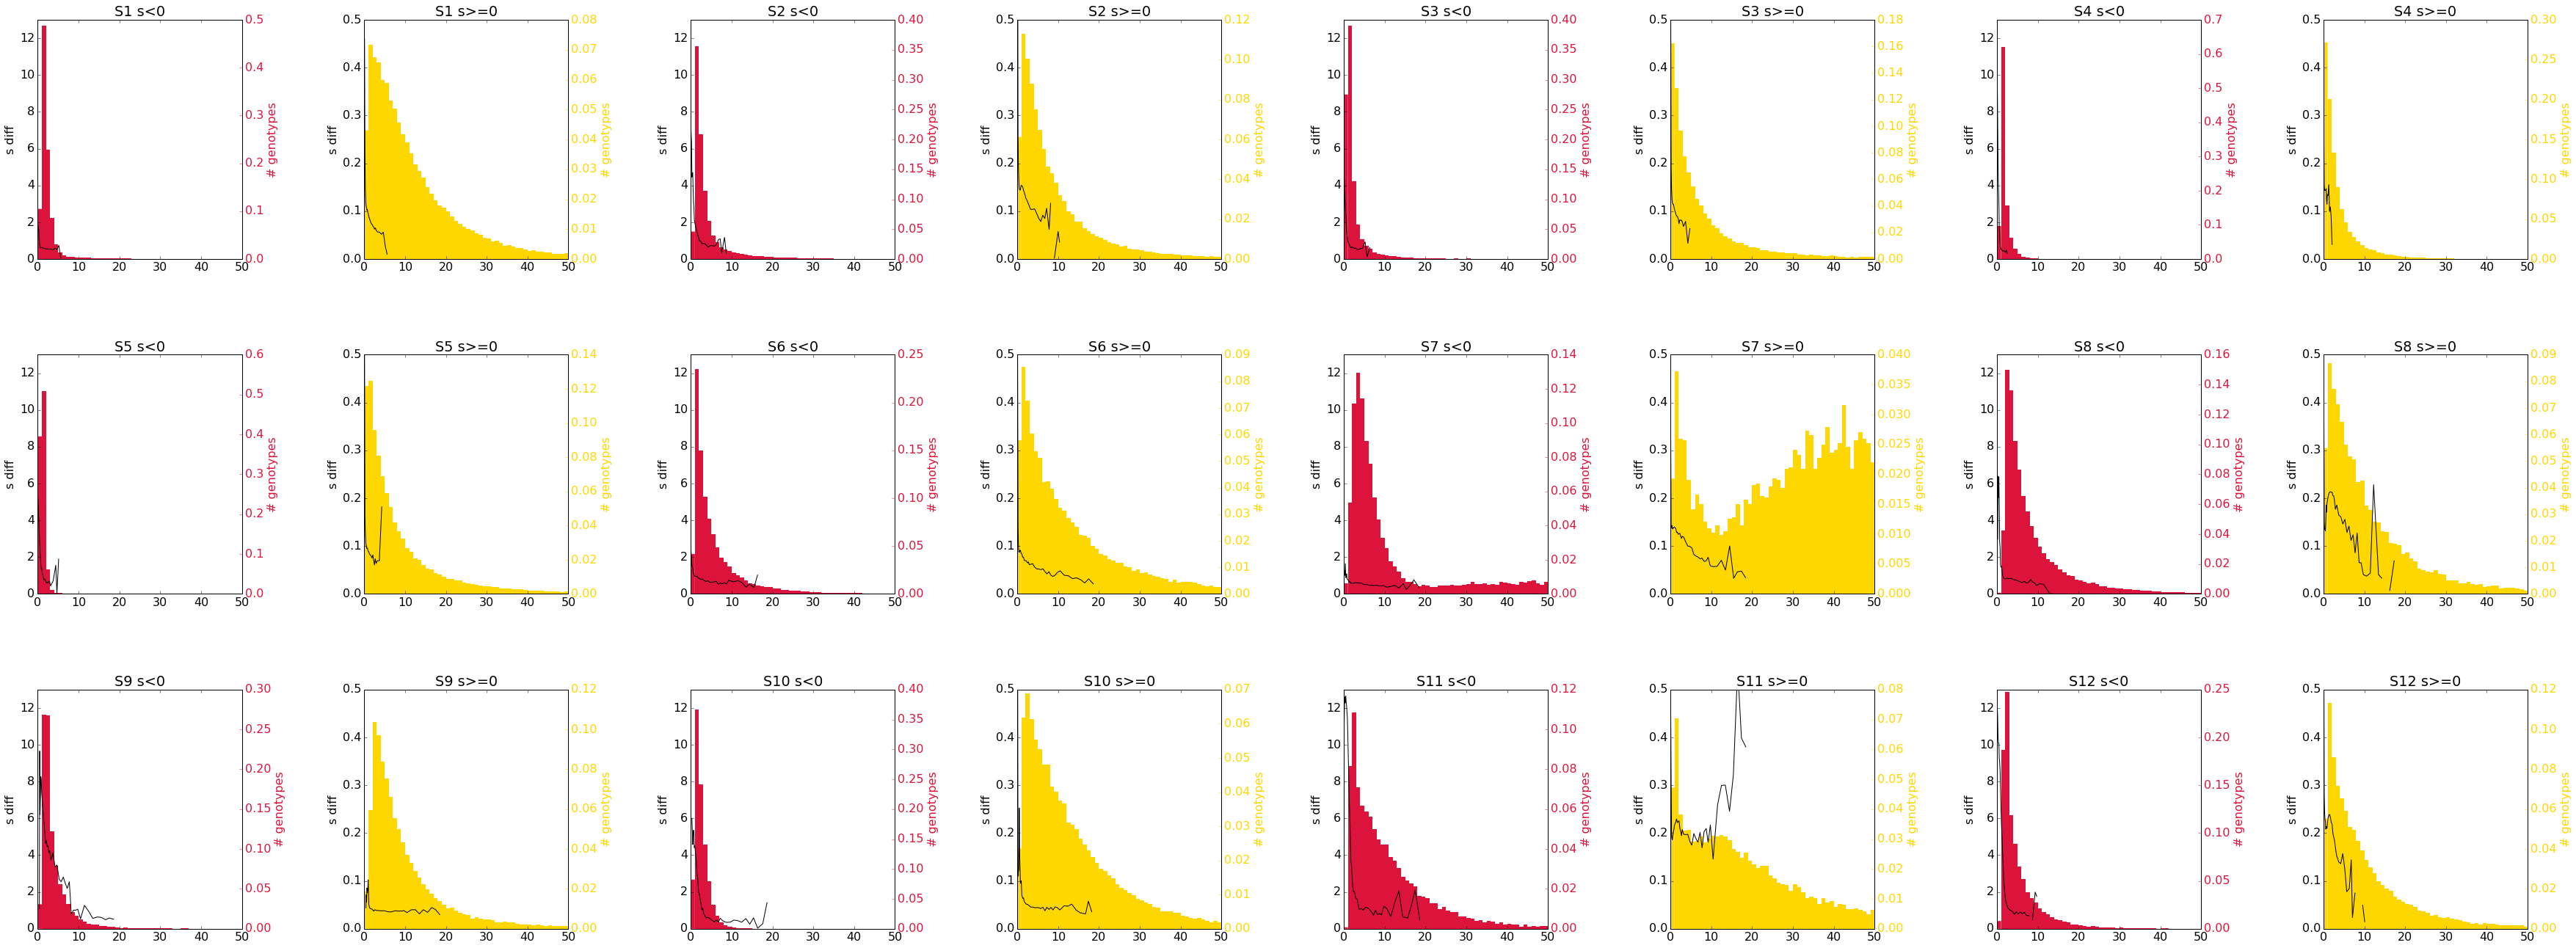

In [218]:
#histogtam of t0 in aa_all vs s_diff(t0)
fig=plt.figure(figsize=(8*7.6,3*7.4))
plt.rcParams.update({'font.size': 16,'legend.fontsize': 16})
plt.subplots_adjust(hspace = 0.4,wspace=0.6)

count=1
for segment in segm_set:
    for mask,color,name,ylim in [
        [aa_all[segment][aa_all[segment]['s']<0.23],'crimson','s<0',13],
        [aa_all[segment][aa_all[segment]['s']>=0.23],'gold','s>=0',0.5]
    ]:
        
        ax1=plt.subplot(3,8,count)
        ax1.hist(mask['t0_fr'],range=(0,50),bins=50,edgecolor='none',color=color,alpha=1,normed=True)
        ax1.set_ylabel('# genotypes', color=color)
        ax1.tick_params('y', colors=color)
        plt.xlim(0,50)
   
        
        ax2=ax1.twinx()
        ax2.plot(nuc_fit_er_avg[segment]['t0_min_'+name],nuc_fit_er_avg[segment]['s_diff_'+name],alpha=1,c='black')
        ax2.set_ylabel('s diff', color='black')
        ax2.tick_params('y', color='black')
        plt.title('S'+str(segment)+' '+name)
        plt.xlim(0,50)
        plt.ylim(0,ylim)
        ax1.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")
        ax2.yaxis.tick_left() 
        ax2.yaxis.set_label_position("left")
        count+=1

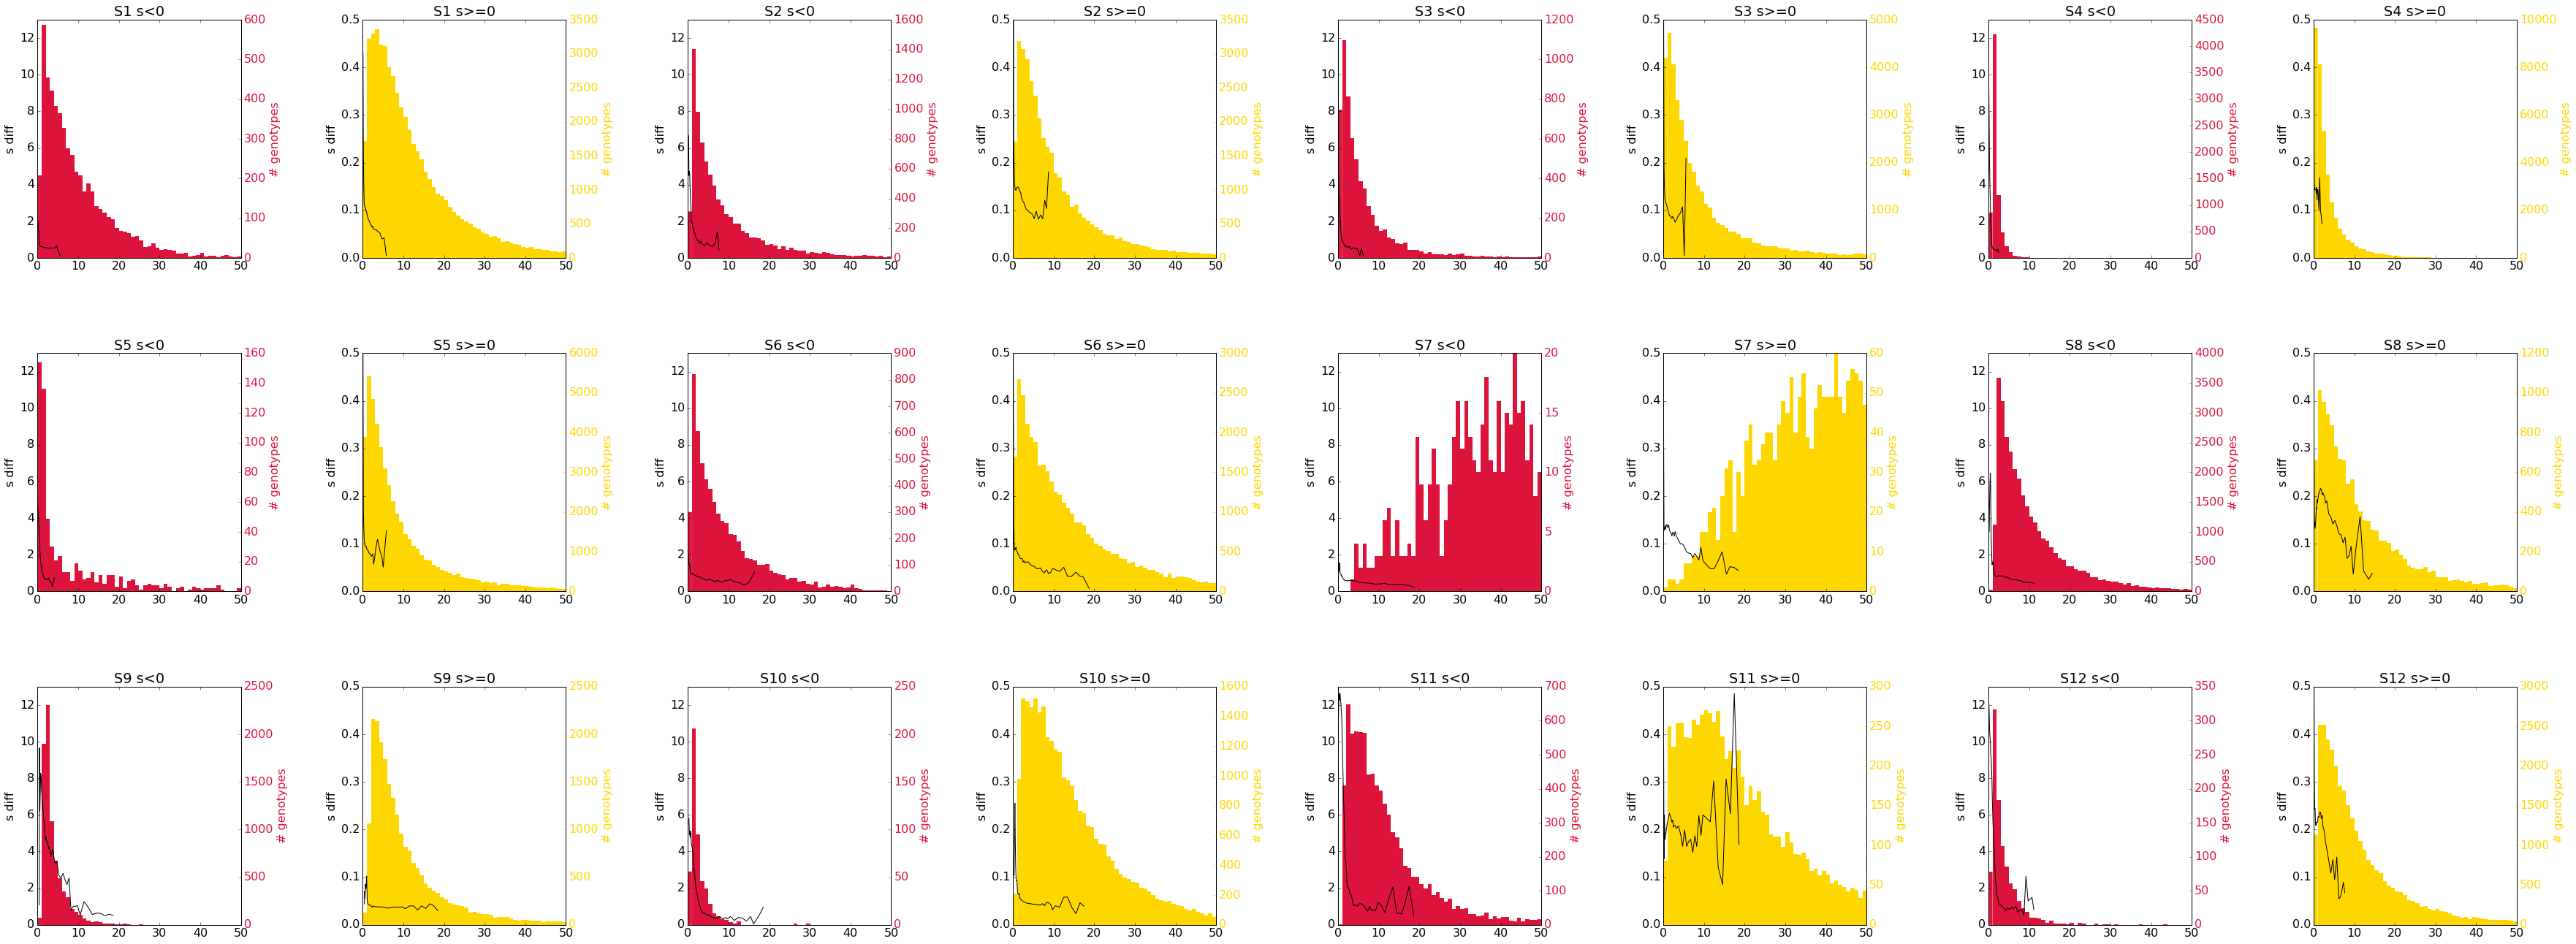

In [11]:
#histogtam of t0 in aa_all vs s_diff(t0) only nat_lib
fig=plt.figure(figsize=(8*7.6,3*7.4))
plt.rcParams.update({'font.size': 16,'legend.fontsize': 16})
plt.subplots_adjust(hspace = 0.4,wspace=0.6)

count=1
for segment in segm_set:
    for mask,color,name,ylim in [
        [aa_all[segment][(aa_all[segment]['nat_lib']==1)&(aa_all[segment]['s']<0.23)],'crimson','s<0',13],
        [aa_all[segment][(aa_all[segment]['nat_lib']==1)&(aa_all[segment]['s']>=0.23)],'gold','s>=0',0.5]
    ]:
        
        ax1=plt.subplot(3,8,count)
        ax1.hist(mask['t0_fr'],range=(0,50),bins=50,edgecolor='none',color=color,alpha=1)#,normed=True)
        ax1.set_ylabel('# genotypes', color=color)
        ax1.tick_params('y', colors=color)
        plt.xlim(0,50)
   
        
        ax2=ax1.twinx()
        ax2.plot(nuc_fit_er_avg[segment]['t0_min_'+name],nuc_fit_er_avg[segment]['s_diff_'+name],alpha=1,c='black')
        ax2.set_ylabel('s diff', color='black')
        ax2.tick_params('y', color='black')
        plt.title('S'+str(segment)+' '+name)
        plt.xlim(0,50)
        plt.ylim(0,ylim)
        ax1.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")
        ax2.yaxis.tick_left() 
        ax2.yaxis.set_label_position("left")
        count+=1

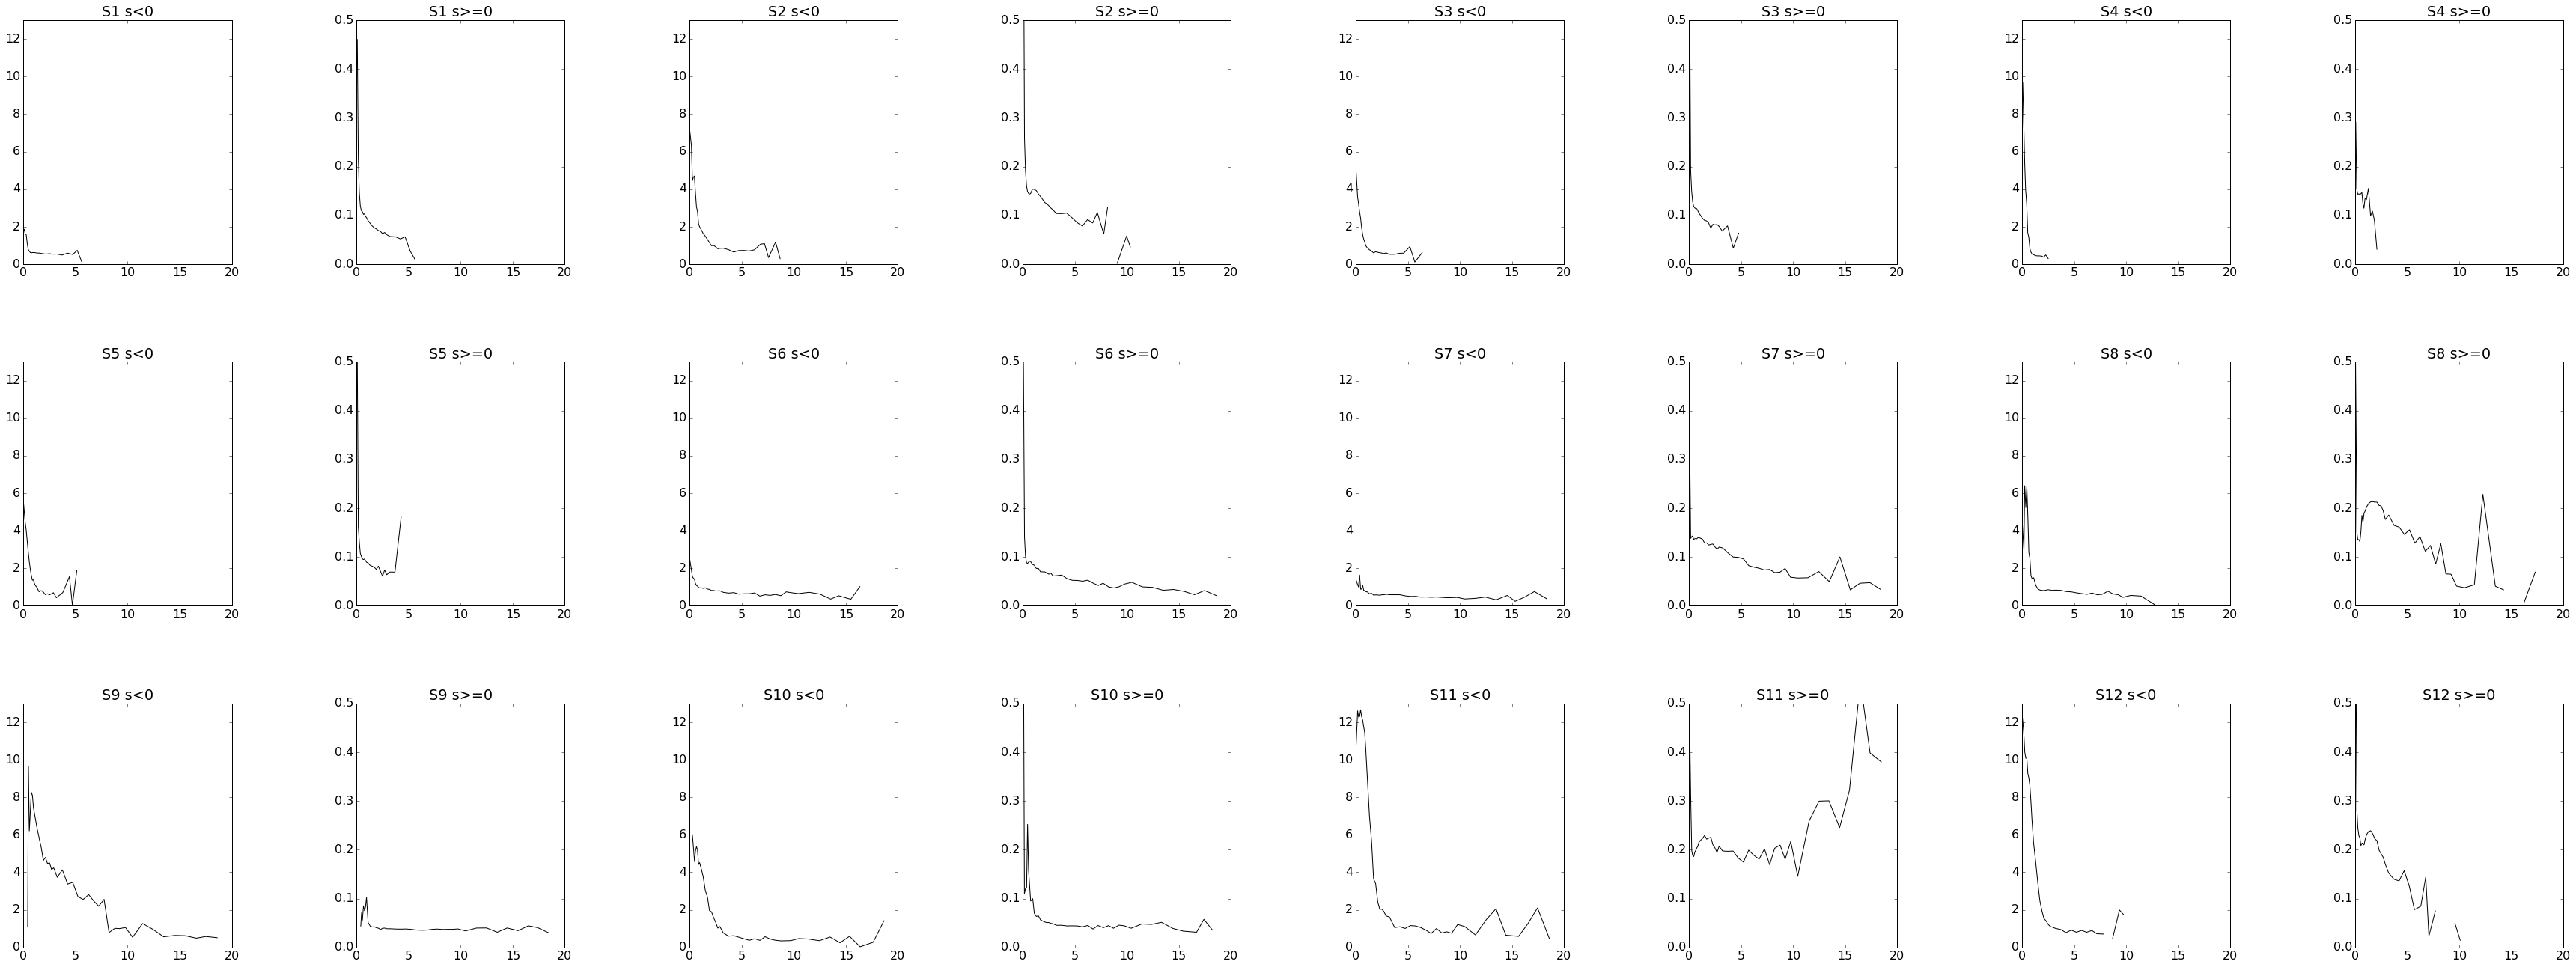

In [223]:
fig=plt.figure(figsize=(8*7.6,3*7.4))
plt.rcParams.update({'font.size': 16,'legend.fontsize': 16})
plt.subplots_adjust(hspace = 0.4,wspace=0.6)

count=1
for segment in segm_set:
    for mask,color,name,ylim in [
        [aa_all[segment][aa_all[segment]['s']<0.23],'crimson','s<0',13],
        [aa_all[segment][aa_all[segment]['s']>=0.23],'gold','s>=0',0.5]
    ]:
        
        plt.subplot(3,8,count)
        plt.plot(nuc_fit_er_avg[segment]['t0_min_'+name],nuc_fit_er_avg[segment]['s_diff_'+name],alpha=1,c='black')

        plt.title('S'+str(segment)+' '+name)
        plt.xlim(0,20)
        plt.ylim(0,ylim)
      
        count+=1

In [44]:
#data of Lucas's R2
statistics=pd.DataFrame()
tmp=[]
for s in segm_set:
    mask=aa_all[s][aa_all[s]['nat_lib']==1]
    statistics.set_value('S'+str(s),'var_nat_lib',np.var(mask['s']))
    statistics.set_value('S'+str(s),'R2',[0.7601,0.6209,0.7865,0.9038,0.4596,0.5175,0.9744,0.8622,0.0111,0.0072,0.8127,0.4943][s-1])

In [18]:
#how I estimate plato value for s_diff
limits_for_big=[[0,0],[2,5],[4,6],[3,5],[1,2],\
 [2,4],[10,15],[10,15],[8,11],\
 [10,15],[10,15],[5,10],[4,7]]

In [251]:
#errors for deleterous (s<0) s_diff[(t0)*f(t0), where f is PDF of t0 distribution in aa_all
for s in segm_set:
    tmp=0
    mask=aa_all[segment][aa_all[segment]['s']<0.23]
    name='s<0'
    error_big=np.nanmean([item[1] for item in np.transpose([nuc_fit_er_avg[s]['t0_min_'+name],nuc_fit_er_avg[s]['s_diff_'+name]]) if \
         (item[0]>=limits_for_big[s][0])&(item[0]<=limits_for_big[s][1])])
    for i in range(len([item for item in boundaries if item<=limits_for_big[s][0]])):
        mask_2=mask[(mask['t0_fr']>=boundaries[i])&(mask['t0_fr']<boundaries[i+1])]
        if (len(mask_2)!=0):
            tmp+=len(mask_2)*nuc_fit_er_avg[s]['s_diff_'+name][i]
        
    mask_2=mask[mask['t0_fr']>boundaries[i+1]]
    tmp+=len(mask_2)*error_big
    tmp=tmp/len(mask)
    print 'S'+str(s),tmp

S1 0.546891604094
S2 0.910168307198
S3 0.595713939481
S4 0.459983052687
S5 0.661727999881
S6 0.735758337094
S7 0.544510872269
S8 0.784567795585
S9 3.50425890672
S10 1.19435971532
S11 2.08531733284
S12 1.43477944787


In [253]:
for s in segm_set:
    tmp=0
    mask=aa_all[segment][aa_all[segment]['s']>=0.23]
    name='s>=0'
    error_big=np.nanmean([item[1] for item in np.transpose([nuc_fit_er_avg[s]['t0_min_'+name],nuc_fit_er_avg[s]['s_diff_'+name]]) if \
         (item[0]>=limits_for_big[s][0])&(item[0]<=limits_for_big[s][1])])
    for i in range(len([item for item in boundaries if item<=limits_for_big[s][0]])):
        mask_2=mask[(mask['t0_fr']>=boundaries[i])&(mask['t0_fr']<boundaries[i+1])]
        if (str(nuc_fit_er_avg[s]['s_diff_'+name][i])!='nan'):
            tmp+=len(mask_2)*nuc_fit_er_avg[s]['s_diff_'+name][i]
        
    mask_2=mask[mask['t0_fr']>boundaries[i+1]]
    tmp+=len(mask_2)*error_big
    tmp=tmp/len(mask)
    print 'S'+str(s),tmp

S1 0.066096312619
S2 0.105984000507
S3 0.0703655977889
S4 0.118785217048
S5 0.0740796470431
S6 0.0534603840853
S7 0.0906968829992
S8 0.124457750288
S9 0.0411094373013
S10 0.0527762104022
S11 0.198321417637
S12 0.148153346323


In [49]:
#mean errors for all
for s in segm_set:
    tmp=0
    for mask,name in [\
                     [aa_all[segment][(aa_all[segment]['s']>=0.23)],'s>=0'],\
                     [aa_all[segment][(aa_all[segment]['s']<0.23)],'s<0']]:
        error_big=np.nanmean([item[1] for item in np.transpose([nuc_fit_er_avg[s]['t0_min_'+name],nuc_fit_er_avg[s]['s_diff_'+name]]) if \
             (item[0]>=limits_for_big[s][0])&(item[0]<=limits_for_big[s][1])])
        for i in range(len([item for item in boundaries if item<=limits_for_big[s][0]])):
            mask_2=mask[(mask['t0_fr']>=boundaries[i])&(mask['t0_fr']<boundaries[i+1])]
            if (str(nuc_fit_er_avg[s]['s_diff_'+name][i])!='nan'):
                tmp+=len(mask_2)*nuc_fit_er_avg[s]['s_diff_'+name][i]

        mask_2=mask[mask['t0_fr']>boundaries[i+1]]
        tmp+=len(mask_2)*error_big
    tmp=tmp/len(aa_all[segment])
    print 'S'+str(s),tmp
    statistics.set_value('S'+str(s),'errors_mean',tmp)

S1 0.276506005255
S2 0.473044431541
S3 0.311311406393
S4 0.261797903708
S5 0.354678486885
S6 0.361040658254
S7 0.291408304754
S8 0.421757373285
S9 1.60900864714
S10 0.568818047566
S11 1.05589816739
S12 0.741079349308


In [45]:
#mean errors for nat_lib
for s in segm_set:
    tmp=0
    for mask,name in [\
                     [aa_all[segment][(aa_all[segment]['nat_lib']==1)&(aa_all[segment]['s']>=0.23)],'s>=0'],\
                     [aa_all[segment][(aa_all[segment]['nat_lib']==1)&(aa_all[segment]['s']<0.23)],'s<0']]:
        error_big=np.nanmean([item[1] for item in np.transpose([nuc_fit_er_avg[s]['t0_min_'+name],nuc_fit_er_avg[s]['s_diff_'+name]]) if \
             (item[0]>=limits_for_big[s][0])&(item[0]<=limits_for_big[s][1])])
        for i in range(len([item for item in boundaries if item<=limits_for_big[s][0]])):
            mask_2=mask[(mask['t0_fr']>=boundaries[i])&(mask['t0_fr']<boundaries[i+1])]
            if (str(nuc_fit_er_avg[s]['s_diff_'+name][i])!='nan'):
                tmp+=len(mask_2)*nuc_fit_er_avg[s]['s_diff_'+name][i]

        mask_2=mask[mask['t0_fr']>boundaries[i+1]]
        tmp+=len(mask_2)*error_big
    tmp=tmp/len(aa_all[segment])
    print 'S'+str(s),tmp
    statistics.set_value('S'+str(s),'errors_mean_nat_lib',tmp)

S1 0.0428255341125
S2 0.0705688183389
S3 0.0552267280292
S4 0.0569971758306
S5 0.050463341512
S6 0.0383801692924
S7 0.0520471604143
S8 0.0819041431932
S9 0.0903923340303
S10 0.0560558442543
S11 0.158378544008
S12 0.116120103162


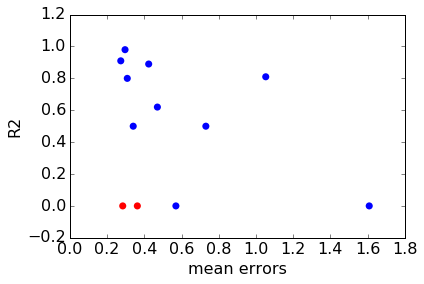

In [267]:
plt.scatter([0.47006875924,0.308210731852,0.273258427524,0.34013036077,0.296155700609,0.423314622499,1.60900864714,0.569614392276,\
1.05263609003,0.730657816831],[0.62, 0.8, 0.91, 0.5, 0.98, 0.89, 0, 0, 0.81, 0.5],edgecolors='',s=50)
plt.scatter([ 0.283770589822,0.362362564267],[0,0],c='r',edgecolors='',s=50)
plt.xlabel('mean errors')
plt.ylabel('R2')


In [46]:
statistics

,var_nat_lib,R2,errors_mean_nat_lib
S1,0.011069,0.7601,0.042826
S2,0.020102,0.6209,0.070569
S3,0.019102,0.7865,0.055227
S4,0.020751,0.9038,0.056997
S5,0.003183,0.4596,0.050463
S6,0.015702,0.5175,0.038380
S7,0.024394,0.9744,0.052047
S8,0.028746,0.8622,0.081904
S9,0.029639,0.0111,0.090392
S10,0.002346,0.0072,0.056056


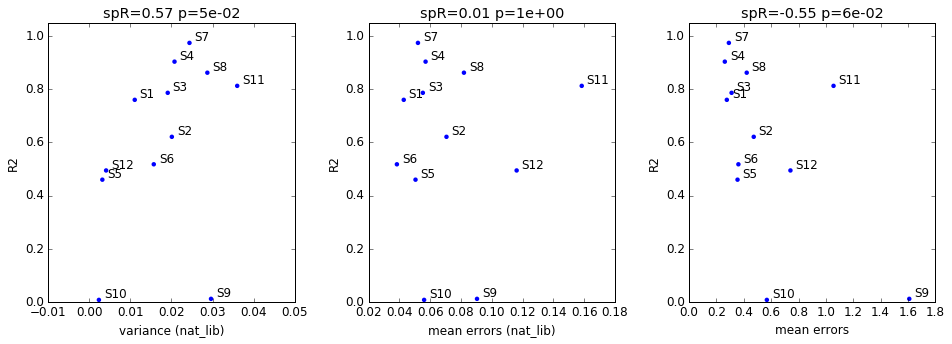

In [61]:
fig=plt.figure(figsize=(3*5.3,5))
plt.rcParams.update({'font.size': 12,'legend.fontsize': 12})
plt.subplots_adjust(hspace = 0.4,wspace=0.3)
count=1
y=statistics['R2']
for x,label in [[statistics['var_nat_lib'],'variance (nat_lib)'],\
                [statistics['errors_mean_nat_lib'],'mean errors (nat_lib)'],[statistics['errors_mean'],'mean errors']]:
    plt.subplot(1,3,count)
    plt.scatter(x,y,edgecolors='')
    plt.ylabel('R2')
    plt.xlabel(label)
    count+=1
    plt.ylim(0,1.05)
    [r,p]=stats.spearmanr(x,y)
    plt.title('spR=%.2f p=%.0e' %(r,p))
    for s in segm_set:
        #plt.annotate(label=,xy=(x[s-1],y[s-1]),xytext=(3, 1.5))
        plt.annotate('S'+str(s), xy = (x[s-1], y[s-1]), xytext = (5,2), textcoords = 'offset points')